In [2]:
%load_ext autoreload
%autoreload 2
%env THEANO_FLAGS=device=gpu1
import sys
sys.path.append("..")

env: THEANO_FLAGS=device=gpu1


In [3]:
from utils.southpark import get_conversations
#southpark stuff
conversations_southpark = get_conversations("/srv/hd7/jheuristic/cartman/sp.json")


In [3]:
from utils.preprocessor import Preprocessor
sp_tokens = Preprocessor.from_conversations(conversations_southpark,verbose=True).tokens[3:]


100%|██████████| 7285/7285 [00:03<00:00, 2048.30it/s]

23281 out of 23281 tokens, coverage=1.00000)


In [4]:
from tqdm import tqdm
with open("/srv/hd7/jheuristic/cartman/OpenSubtitles2016.en-ru.en") as f:
    opensub_lines = [['opensub',line] for line in tqdm(f)]
    
batch_size = 100
opensub_conv_chunks = [opensub_lines[i:i+batch_size] 
                       for i in range(0,len(opensub_lines) - batch_size +1,batch_size)]


18713837it [00:15, 1198265.96it/s]


In [ ]:
os_tokens = Preprocessor.from_conversations(opensub_conv_chunks,max_tokens=50000,verbose=True).tokens[3:]

In [ ]:
preproc = Preprocessor(list(set(os_tokens+sp_tokens)))

In [10]:
import pickle
with open("/srv/hd7/jheuristic/Downloads/opensub_en_tokens.pcl",'w') as fout:
    pickle.dump(preproc.tokens,fout)

In [5]:
from utils.preprocessor import Preprocessor
import pickle
with open("/srv/hd7/jheuristic/Downloads/opensub_en_tokens.pcl") as fin:
    preproc = Preprocessor(pickle.load(fin))

../utils/preprocessor.py:22: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  token_to_ix = {t:i for i,t in enumerate(tokens)}
../utils/preprocessor.py:23: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  token_to_ix = defaultdict(lambda:token_to_ix["UNK"],token_to_ix)


# model

In [9]:
from models.context_model import ConversationModelCTX
ctx_window,ctx_line_len = 3,10

model = ConversationModelCTX(preproc,(None,ctx_window,ctx_line_len),bottleneck_size=2048,context_size=256)

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 4004.)
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:228: UserWarning: You are giving Recurrence an input sequence of undefined length (None).
Make sure it is always above <unspecified>(n_steps) you specified for recurrence
  "Make sure it is always above {}(n_steps) you specified for recurrence".format(n_steps or "<unspecified>"))
/home/jheuristic/thenv/local/lib/python2.7/site-packages/agentnet/agent/recurrence.py:453: UserWarning: Warning: recurrent loop without unroll_scan got nonempty random state updates list. That happened because there is some source of randomness (e.g. dropout) inside recurrent step graph. To compile such graph, one must either call .get_automatic_updates() right after .get_output and pass these updates to a function, or use no_defalt_updates=True when compiling theano.function.
  warn("Warning: recurrent loop without unroll_sc

# training

In [10]:
conversations = conversations_southpark + opensub_conv_chunks

In [35]:
max_len=30
batch_size=100
n_epochs=100

In [26]:
from utils.generate import get_samples_with_context,iterate_minibatches

convs_ix = preproc.preprocess_conversations(conversations,verbose=True,max_len=max_len)

import numpy as np
prev_ctx,prev_phrases,reference_answers = map(np.stack,
                                              get_samples_with_context(convs_ix,context_window_size=ctx_window,
                                                                       padder = preproc.token_to_ix["PAD"],
                                                                       speaker_filter = lambda s1,s2: True).T
                                             )

prev_ctx = prev_ctx[:,:,:ctx_line_len]
prev_ctx,prev_phrases,reference_answers= map(lambda v: v.astype('int32'),[prev_ctx,prev_phrases,reference_answers])

100%|██████████| 194423/194423 [10:37<00:00, 304.78it/s]


In [ ]:
epoch_counter = 1
ce = []

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for _ in range(n_epochs):
    for b_c,b_x,b_y in iterate_minibatches([prev_ctx,prev_phrases,reference_answers],batch_size,shuffle=True):
        ce.append(model.train_fun(b_c,b_x,b_y))
        
        epoch_counter +=1
        
        if epoch_counter %25==0:
            print epoch_counter,'iterations...'
    print "beginning new loop..."
    plt.plot(ce)
    plt.show()
    
    ph =preproc.ix_to_phrase(b_x[0])
    print 'A:', ph
    print 'B:', model.reply(ph)
    print 'B true:',preproc.ix_to_phrase(b_y[0])
        

11300 iterations...


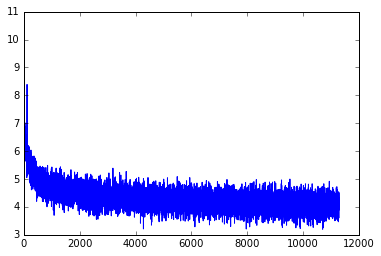

In [30]:
from agentnet.utils.persistence import save
save(model.decoder_training_rec,"/srv/hd7/jheuristic/agentnet_snapshots/opensub_context_cm_2048n_cartman_epoch%i.pcl"%epoch_counter)

In [ ]:
model.reply("Hello there.")